In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from google.cloud import bigquery
client = bigquery.Client()


# Commuter Trips

## Top 5 most popular commuter trips

In order to identify the 5 most popular commuter trips, we must first define what a commuter trip is. In order to do this, we consider characteristics of a commuter trip.  We set the following 4 criteria:

1. Since by definition commuters are going from home to work, or vice-versa, commuter trips must not be round trips. In other words, trips should start and end at different locations.
2. Most commuters will not travel on weekends and public holidays. While some commuters will work weekends and holidays, this accounts for a minority, and accounting for trips on these days might increase our false positives (for example, we would imagine that most trips taken on say 4th of July are leisurely, even if some are for work).
3. Most commuters will work during the day, and prime commuting time is between 6am - 9:59am (prime time for leaving for work) and between 4pm - 7:59pm (prime time for leaving from work). The range should cover most of regular commuters, and provides a large enough window to account for individuals with different work hours (for example, younger people tend to work later hours and also arrive later).
4. Duration of the trips will matter. Commuters will most likely choose a different form of transportation if their journey on a bike is too time. At the same time, if it is too short, they may opt to walk rather than spend money on renting a bike. For our definition, we require trips to last at least 5 minutes, but not more than 30 minutes. We showed in Part 2 that 5 minute trips are most likely tests conducted near the Lyft HQ. For trips >30min, since there is an extra charge for longer durations than 30mins (as discussed in class), this would not sustainable, and customers would likely find another way to commute.

We could have added additional criteria, such as evaluating whether the start station of the morning trip is from a residential location, rather than say business to business (some people might use these bikes to go between locations during work). While our definition will not be perfect and will not capture every single commuter trip in the dataset, it should capture a large portion of commuter trips without having a large false positive rate. 

As a side note, station pair order matters when we count distinct commuter trips. For example, a trip at 8am from station A to station B does NOT count as the same station pair as a trip at 6pm from station B to station A. We count commuter trips starting and ending at different locations as distinct, meaning that for the top 5 most popular trips, we may very well see both A to B and B to A.

In order to tackle this question, we first build a view that corresponds to public holidays during this time period. This was done manually by uploading a [csv](https://github.com/mids-w205-schioberg/project-1-siduojiang/blob/assignment/holidays.csv) file into Google BigQuery and storing it as a table. The following table shows the dates and first 5 entries of the holidays table.

In [5]:
%%bigquery

SELECT * FROM `round-ring-276215.bikeshare_views.holidays` 
ORDER BY time
LIMIT 5

,time,day
0,2013-01-01,New Year's Day
1,2013-01-21,Martin Luther King Jr. Day
2,2013-02-18,Washington's Birthday
3,2013-05-27,Memorial Day
4,2013-07-04,Independence Day


Based on this operational definition of commuters, we arrive at the following trips as the top 5 most popular commuter trips in our dataset.

In [12]:
commuter_trips = '''
WITH commuter_trips AS 
  (SELECT * FROM
     #LEFT JOIN with the holidays table to capture all entries in the bikeshare_trips table
     #Keep only places the holidays table IS NULL (non-holidays)
    (SELECT trips.* FROM `bigquery-public-data.san_francisco.bikeshare_trips` trips
      LEFT JOIN `round-ring-276215.bikeshare_views.holidays` holidays
      ON holidays.time =  CAST(trips.start_date AS DATE)
      WHERE holidays.time IS NULL) trips_non_holiday
    WHERE EXTRACT(DAYOFWEEK FROM start_date) BETWEEN 2 AND 6
      AND (EXTRACT(HOUR FROM start_date) BETWEEN 6 AND 9
        OR EXTRACT(HOUR FROM start_date) BETWEEN 16 AND 19)
      AND duration_sec BETWEEN (60*5) AND (60*30)
      AND start_station_id != end_station_id)        
  SELECT stations_1.name start_station_name, stations_2.name end_station_name, COUNT(*) num_trips 
    FROM commuter_trips 
    JOIN `bigquery-public-data.san_francisco.bikeshare_stations` stations_1
    ON commuter_trips.start_station_id = stations_1.station_id 
    JOIN `bigquery-public-data.san_francisco.bikeshare_stations` stations_2
    ON commuter_trips.end_station_id = stations_2.station_id 
  GROUP BY start_station_name, end_station_name
  ORDER BY num_trips DESC
  LIMIT 5
'''

df_commuter_trips = client.query(commuter_trips).to_dataframe()

In [13]:
df_commuter_trips

,start_station_name,end_station_name,num_trips
0,Harry Bridges Plaza (Ferry Building),2nd at Townsend,5458
1,2nd at Townsend,Harry Bridges Plaza (Ferry Building),5260
2,San Francisco Caltrain (Townsend at 4th),Harry Bridges Plaza (Ferry Building),5019
3,Embarcadero at Folsom,San Francisco Caltrain (Townsend at 4th),4850
4,Steuart at Market,2nd at Townsend,4697


It is interesting to note that Harry Bridges Plaza (Ferry Building) to 2nd at Townsend, as well as the reverse, both appear in the table. San Francisco Caltrain (Townsend at 4th) also appears multiple times in the table. In order to save commuter trips as a separate table for easy access in the future, we create a view of this table using the following SQL command:

```
CREATE VIEW `round-ring-276215.bikeshare_views.commuter_trips` AS
(SELECT trips_non_holiday.*, stations_1.name official_start_station_name, stations_2.name official_end_station_name FROM

   #LEFT JOIN with the holidays table to capture all entries in the bikeshare_trips table
   #Keep only places the holidays table IS NULL (non-holidays)

  (SELECT trips.* FROM `bigquery-public-data.san_francisco.bikeshare_trips` trips
    LEFT JOIN `round-ring-276215.bikeshare_views.holidays` holidays
    ON holidays.time =  CAST(trips.start_date AS DATE)
    WHERE holidays.time IS NULL) trips_non_holiday
    
  #JOIN to the stations table twice in order to get the official start and end station names
  #We discovered some name discrepancies in part 1
  
  JOIN `bigquery-public-data.san_francisco.bikeshare_stations` stations_1
    ON trips_non_holiday.start_station_id = stations_1.station_id 
  JOIN `bigquery-public-data.san_francisco.bikeshare_stations` stations_2
    ON trips_non_holiday.end_station_id = stations_2.station_id   
  WHERE EXTRACT(DAYOFWEEK FROM start_date) BETWEEN 2 AND 6
    AND (EXTRACT(HOUR FROM start_date) BETWEEN 6 AND 8
      OR EXTRACT(HOUR FROM start_date) BETWEEN 17 AND 19)
    AND duration_sec BETWEEN (60*5) AND (60*30)
    AND start_station_id != end_station_id)
```

Based on the view above, we can easily see that there are a total of 356012 trips that we consider commuter trips.

In [19]:
%%bigquery

SELECT COUNT(*) num_commuter_trips
FROM `round-ring-276215.bikeshare_views.commuter_trips`

,num_commuter_trips
0,356012


We can also find the average duration and standard deviation of the duration.

In [65]:
%%bigquery

SELECT ROUND(AVG(duration_sec) / 60, 2) ave_commuter_mins, ROUND(STDDEV(duration_sec) /60, 2) std_commuter_mins
FROM `round-ring-276215.bikeshare_views.commuter_trips` 

,ave_commuter_mins,std_commuter_mins
0,10.14,3.92


### Top stations for corporate discount

Next, we look further into commuter trips, we ask the question: 

**What are the most popular end stations from "commuter trips" in the morning commuter hours or most popular start stations from "commuter trips" in the afternoon hours?**

The reason is that end stations for morning trips, and start stations from afternoon trips, should correspond to people's locations of their workplace. Such locations with lots of such trips would represent centralized corporate centers with untapped potential, which would make businesses near these stations prime target for a corporate commuter discount. In addition, in order to consider where we advertise for a corporate discount, we should narrow the query from the first question down further to consider only areas with high concentration of corporate offices. The following query, using the view created previously, gives us this information.

In [23]:
corporate_stations = '''
SELECT corporate_station, COUNT(*) counts FROM
  (SELECT official_start_station_name corporate_station FROM `round-ring-276215.bikeshare_views.commuter_trips` 
   UNION ALL
   SELECT official_end_station_name corporate_station FROM `round-ring-276215.bikeshare_views.commuter_trips`)
GROUP BY corporate_station
ORDER BY counts DESC
'''

df_corporate_stations = client.query(corporate_stations).to_dataframe()

The top 10 stations are below:

In [64]:
df_corporate_stations.head(10)

,corporate_station,counts
0,San Francisco Caltrain (Townsend at 4th),86085
1,San Francisco Caltrain 2 (330 Townsend),54621
2,Harry Bridges Plaza (Ferry Building),36419
3,Temporary Transbay Terminal (Howard at Beale),35985
4,2nd at Townsend,33107
5,Steuart at Market,31018
6,Embarcadero at Sansome,27997
7,Townsend at 7th,24287
8,Market at Sansome,23997
9,Market at 10th,22360


We will visualize the distribution of all such stations in a bar plot.

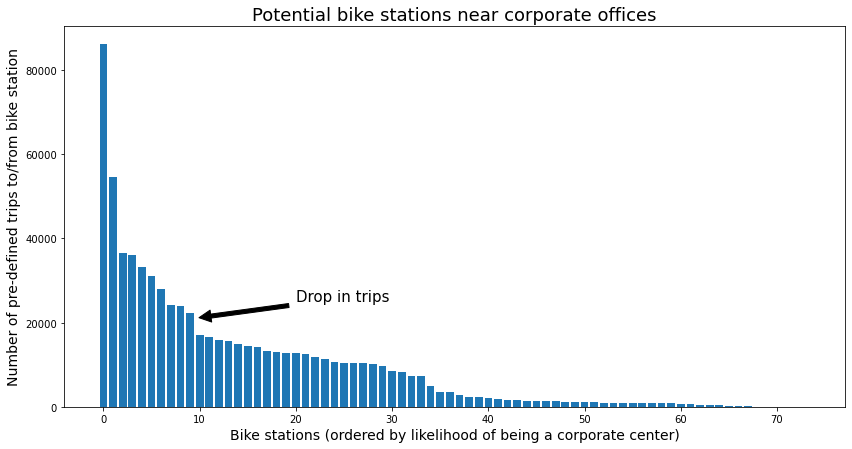

In [67]:
fig = plt.figure(figsize = (14,7))
plt.bar(df_corporate_stations.index, df_corporate_stations.counts)
plt.title("Potential bike stations near corporate offices", fontsize = 18)
plt.xlabel("Bike stations (ordered by likelihood of being a corporate center)", fontsize = 14)
plt.ylabel("Number of pre-defined trips to/from bike station", fontsize = 14)
plt.annotate('Drop in trips', xy=(9.4, 21000), xytext=(20, 25000),
            arrowprops=dict(facecolor='black', shrink=0.05),
            fontsize = 15)
plt.show()

Based on the plot above, we see that there are two locations, both near San Francisco Caltrain, which might represent corporate centers. There also seems to be a drop in number of trips after the 10th station. As a result, we should consider corporate offices from the first 10 stations.

### Recruiting Customers for a Subscription

One potential market are commuters who tried the service once, but perhaps forgot about signing up or need an additional incentive to make biking a full-time routine. As a result, we will look for non-subscribers (Customers) who we consider commuters. The following shows the top trips for which percentage of Customers were the largest. To eliminate station pairs for which there were very few trips, we require that the total number of trips for a station pair be at least 1000.

In [26]:
%%bigquery
WITH subscriber_trips AS
    (SELECT stations_1.name start_name, stations_2.name end_name, COUNT(*) subscriber_trips,  
    FROM `round-ring-276215.bikeshare_views.commuter_trips` commuter_trips
    JOIN `bigquery-public-data.san_francisco.bikeshare_stations` stations_1
      ON commuter_trips.start_station_id = stations_1.station_id 
    JOIN `bigquery-public-data.san_francisco.bikeshare_stations` stations_2
      ON commuter_trips.end_station_id = stations_2.station_id 
    WHERE subscriber_type = 'Subscriber'
    GROUP BY start_name, end_name),
customer_trips AS
    (SELECT stations_1.name start_name, stations_2.name end_name, COUNT(*) customer_trips,  
    FROM `round-ring-276215.bikeshare_views.commuter_trips` commuter_trips
    JOIN `bigquery-public-data.san_francisco.bikeshare_stations` stations_1
      ON commuter_trips.start_station_id = stations_1.station_id 
    JOIN `bigquery-public-data.san_francisco.bikeshare_stations` stations_2
      ON commuter_trips.end_station_id = stations_2.station_id 
    WHERE subscriber_type = 'Customer'
    GROUP BY start_name, end_name)
SELECT s.start_name, s.end_name, c.customer_trips, s.subscriber_trips, 
       ROUND(c.customer_trips/(s.subscriber_trips + c.customer_trips) * 100, 2) percent_customer_trips
FROM subscriber_trips s
    JOIN customer_trips c
    ON s.start_name = c.start_name
    AND s.end_name = c.end_name
WHERE c.customer_trips + s.subscriber_trips >= 1000
ORDER BY percent_customer_trips DESC
LIMIT 5

,start_name,end_name,customer_trips,subscriber_trips,percent_customer_trips
0,Embarcadero at Sansome,Harry Bridges Plaza (Ferry Building),176,1164,13.13
1,Harry Bridges Plaza (Ferry Building),Embarcadero at Sansome,316,2625,10.74
2,San Francisco Caltrain (Townsend at 4th),Embarcadero at Sansome,89,1500,5.60
3,Harry Bridges Plaza (Ferry Building),2nd at South Park,52,948,5.20
4,San Francisco Caltrain (Townsend at 4th),Market at 10th,61,1240,4.69


We can see that the top entries in this chart that Embarcadero at Sansome to Harry Bridges Plaza (Ferry Building) has a high percentage of Customers compared to Subscribers (13.13%), as does the opposite route (likely afternoon vs morning trips). Therefore, focusing customers on this particular route would make the most sense.

### Discounts based on availability

In part 2 of of the project, we looked at overall bike availability based on station. Here, in order to make recommendations more taylored to commuters, we will use similar queries to look at bike availability specifically during commuter hours. Namely, we ask the question:

**During prime commuting hours, which bike stations have the most bikes available, and which have the least?**

In order to answer this question, we will look at the average number of bikes available at each station during both morning and afternoon commuter hours. For example, for the station Embarcadero at Sansome, we will have two entries, one for average number of bikes between 6am - 9:59am, and one between 4pm - 7:59pm. In addition, to normalize for the fact that some stations are smaller than others, we will divide by the average number of available docks (available bikes + empty 

In [41]:
morning_afternoon_availability = '''
WITH bike_capacity AS
(SELECT status.station_id, AVG(bikes_available + docks_available) num_available
FROM `bigquery-public-data.san_francisco.bikeshare_status` status
GROUP BY station_id
)
SELECT stations.name station_name, ROUND(AVG(status.bikes_available / num_available) * 100, 2) average_pct_of_bikes_available,
       CASE WHEN EXTRACT(HOUR FROM status.time) BETWEEN 6 AND 9 THEN 'morning_commuter_hours'
            WHEN EXTRACT(HOUR FROM status.time) BETWEEN 16 AND 19 THEN 'afternoon_commuter_hours'
       END segment
FROM `bigquery-public-data.san_francisco.bikeshare_status` status
JOIN `bigquery-public-data.san_francisco.bikeshare_stations` stations
  ON status.station_id = stations.station_id 
JOIN bike_capacity
  ON bike_capacity.station_id = status.station_id
GROUP BY station_name, segment
HAVING segment IS NOT NULL
ORDER BY average_pct_of_bikes_available DESC
'''

df_morning_afternoon_availability = client.query(morning_afternoon_availability).to_dataframe()

Below are the results for the top 5 stations with the MOST average percentage of bikes available. We can see that San Francisco Caltrain (Townsend at 4th) and Harry Bridges Plaza (Ferry Building) both have a large proportional of bikes available during afternoon commuter hours.

In [42]:
df_morning_afternoon_availability.head()

,station_name,average_pct_of_bikes_available,segment
0,San Francisco Caltrain (Townsend at 4th),62.41,afternoon_commuter_hours
1,Harry Bridges Plaza (Ferry Building),61.90,afternoon_commuter_hours
2,5th St at Folsom St,58.88,afternoon_commuter_hours
3,San Francisco Caltrain 2 (330 Townsend),57.63,morning_commuter_hours
4,California Ave Caltrain Station,56.78,morning_commuter_hours


Below are the results for the top 5 stations with the LEAST average percentage of bikes available. We can see that Cyril Magnin St at Ellis St has limit bike available during both morning and afternoon commuter hours.

In [43]:
df_morning_afternoon_availability.tail()

,station_name,average_pct_of_bikes_available,segment
143,S. Market st at Park Ave,32.05,morning_commuter_hours
144,2nd at Folsom,28.81,morning_commuter_hours
145,S. Market st at Park Ave,27.51,afternoon_commuter_hours
146,Cyril Magnin St at Ellis St,15.03,morning_commuter_hours
147,Cyril Magnin St at Ellis St,11.54,afternoon_commuter_hours


We now produce a visualization of percentage of bikes available for both afternoon and morning commuter hours.

In [66]:
#We merge the morning and afternoon into a single database with multiple entries based on station name
morning = df_morning_afternoon_availability.loc[df_morning_afternoon_availability.segment == 'morning_commuter_hours']
afternoon = df_morning_afternoon_availability.loc[df_morning_afternoon_availability.segment == 'afternoon_commuter_hours']
df_availability = morning.merge(afternoon, on='station_name').iloc[:, [0,1,3]]
df_availability.columns = ['station_name', 'average_pct_of_bikes_available_morn', 'average_pct_of_bikes_available_afternoon']

#This is just how we sort stations for plotting
df_availability['summed'] = df_availability.average_pct_of_bikes_available_morn + df_availability. average_pct_of_bikes_available_afternoon
df_availability = df_availability.sort_values('summed', ascending = False) 


In [79]:
df_availability.tail()

,station_name,average_pct_of_bikes_available_morn,average_pct_of_bikes_available_afternoon,summed
69,Commercial at Montgomery,36.80,34.51,71.31
70,Market at 10th,33.55,36.28,69.83
72,2nd at Folsom,28.81,33.84,62.65
71,S. Market st at Park Ave,32.05,27.51,59.56
73,Cyril Magnin St at Ellis St,15.03,11.54,26.57


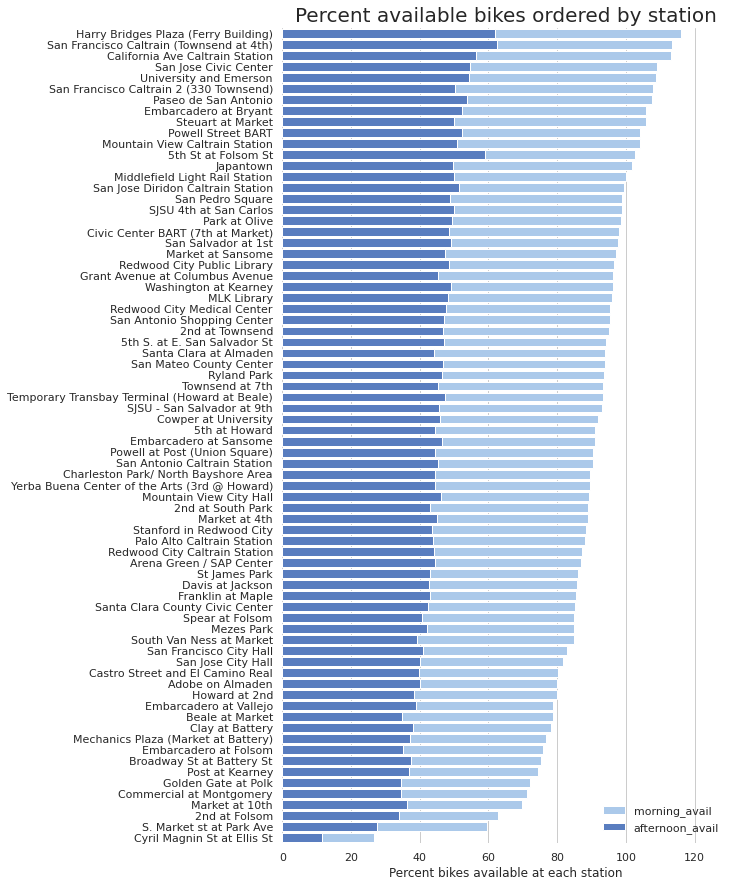

In [85]:
# Plot the total crashes
f, ax = plt.subplots(figsize=(8, 15))
sns.set(style="whitegrid")

sns.set_color_codes("pastel")
sns.barplot(x="summed", y="station_name", data=df_availability,
            label="morning_avail", color="b").set_title('Percent available bikes ordered by station', fontsize = 20)

# Plot the crashes where alcohol was involved
sns.set_color_codes("muted")
sns.barplot(x="average_pct_of_bikes_available_afternoon", y="station_name", data=df_availability,
            label="afternoon_avail", color="b")

ax.legend(ncol=1, loc="lower right", frameon=False)
ax.set(xlim=(0, 130), ylabel="",
       xlabel="Percent bikes available at each station")
sns.despine(left=True, bottom=True)


Based on the plot, we can see that Cyril Magnin St at Ellis St is chronically low on bikes during commuter hours, and appears to be an ourlier. Several of the stations at the top of the plot are high in the number of bikes available, but there doesn't appear to be any outliers.

## Final Recommendation Based on Commuter Trips

Based on the tables and visualizations generated above, we produce the following recommendations:

1. df
2. 

# Non-commuter criteria

Least used bikes and maybe for the least used bike, the stations at which it is parked (to show there is movement; just encourage more movement with discount to offset maintainence costs).

Since we saw in Part 1 that Customers tend to take more intercity trips than subscribers, a natural question to ask is do Customers also take longer trips than Subscribers, and if so, is there any way we can convert those Customers to Subscribers? Different model that charges extra for rentals that are too short! General customers versus subscribers: duration of trips is different; maybe offer better subscription services for longer durations so people can take day trips between cities. Customers tend to travel in between cities more (Part 1). People don't want to subscribe but rather just do single trips.

Best day of the week and hour to offer general discount to everyone during this 3 hour window -- try for free during these times for first time customers

Change in ridership during weekend versus weekday. Top 5 starting stations during morning hours. Top 5 starting stations during the weekend morning hours. Likely different people since it's different distribution of starting stations. Maybe offer discount to subscribers who use service even on weekends, and not just to commute.